Next: https://github.com/arunarn2/HierarchicalAttentionNetworks/blob/master/HierarchicalAttn.py

In [2]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np

In [51]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score as scikit_f1_score

In [5]:
import tensorflow as tf
import tensorflow_hub as hub

In [6]:
from keras import backend as K

from keras.models import Model, Input
from keras.layers.merge import add
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Bidirectional, Lambda
from keras.regularizers import l2

from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import RMSprop, Adam, SGD, Adamax
from keras.models import load_model

from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

#### Custom Functions

In [7]:
from src.load_data import load_data
from src.callbacks import PlotCurves
from src.eval_metrics_seq import f1_macro, f1_micro

### Load Data

In [8]:
train_data, valid_data, test_data, metadata = load_data()

### Prepare data

In [9]:
max_len = 60
n_tags = 2
batch_size = 2

In [10]:
def get_input(data_, max_len, n_tags, is_test=False, limit=None):
    
    X = []
    for article in data_:
        new_seq = []
        for i in range(max_len):
            try:
                new_seq.append(article['sentences'][i]['sentence'].replace('\n', '').strip().lower())
            except:
                new_seq.append("ENDPAD")
        X.append(new_seq)
    
    if not is_test: 
        y = [[sent['label'] for sent in article['sentences']] for article in data_]
        y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=0)
        y = [[to_categorical(lab, num_classes=n_tags) for lab in sent] for sent in y]
    else:
        y = [sent['label'] for article in data_ for sent in article['sentences']]
    
    if not limit:
        limit = len(X) if len(X)%2 == 0 else len(X)-1

    return np.array(X)[:limit], np.array(y)[:limit]

In [11]:
X_tra, y_tra = get_input(train_data, max_len, n_tags, False)
X_val, y_val = get_input(valid_data, max_len, n_tags, False)
X_test, y_test = get_input(test_data, max_len, n_tags, True)

In [12]:
X_tra.shape, X_val.shape, X_test.shape

((251, 60, 2), (32, 60, 2), (441,))

### Load ELMo

In [18]:
sess = tf.Session()
K.set_session(sess)

In [19]:
elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)

## Build Model

In [20]:
def ELMoEmbedding(x):
    embeds = []
    for art in tf.unstack(tf.transpose(x, (1, 0))):
        embeds.append(elmo(tf.squeeze(tf.cast(art, tf.string)), signature="default", as_dict=True)["default"])
    return tf.stack(embeds, 1)

In [21]:
def build_lstm_model(max_len, n_tags):
    
    input_text = Input(shape=(max_len,), dtype="string")
    
    embedding = Lambda(ELMoEmbedding, output_shape=(None, None, max_len, 1024))(input_text)
    
    dns = Dense(512, activation='relu')(embedding)
    
    dns = Dense(256, activation='relu')(dns)
    
    x = Bidirectional(LSTM(units=128, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2))(dns)

    x_rnn = Bidirectional(LSTM(units=128, return_sequences=True,
                               recurrent_dropout=0.2, dropout=0.2))(x)

    x = add([x, x_rnn])  # residual connection to the first biLSTM

    out = TimeDistributed(Dense(n_tags, activation="softmax"))(x)
    
    return Model(input_text, outputs=out)

In [22]:
learningrate=0.001
optimizer = Adam(lr=learningrate)
optimizer_str = 'Adam'
loss = 'binary_crossentropy'
metrics = ['acc', f1_macro, f1_micro]

In [23]:
model = build_lstm_model(max_len, n_tags)
model.summary()

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [30]:
model_name = 'RQ2_elmo_model_0' + \
             '_maxlen_' + str(max_len) + \
             '_' + optimizer_str + \
             '_lr_' + str(learningrate) + \
             '_loss_' + loss
#              '_with_learnin_rate_reduction'

model_dir = './Model/' + model_name.split('model')[0] + 'model/' + model_name
results_file = os.path.join(model_dir, 'model_results_file.txt')

('RQ2_elmo_model_0_maxlen_60_Adam_lr_0.001_loss_binary_crossentropy',
 './Model/RQ2_elmo_model/RQ2_elmo_model_0_maxlen_60_Adam_lr_0.001_loss_binary_crossentropy')

### Train Model

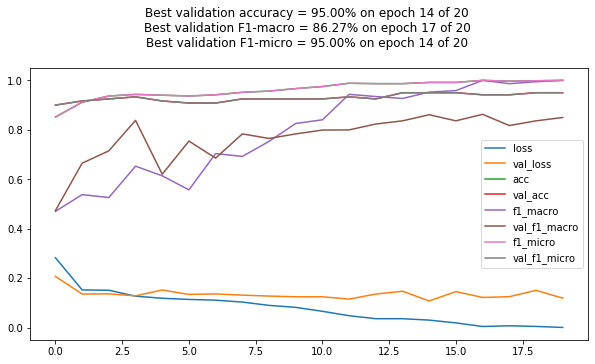

In [24]:
## Sequential Model
model.fit(X_tra, y_tra, 
          epochs=20, 
          batch_size=batch_size, 
          validation_data=(X_val, y_val),
          callbacks=[
              PlotCurves(model_name=model_name)
          ])

### Load the best Model

In [32]:
model_name

'RQ2_elmo_model_0_maxlen_60_Adam_lr_0.001_loss_binary_crossentropy'

In [33]:
best_model = load_model(os.path.join(model_dir, model_name + '_best_f1_macro_model.h5'), 
                        custom_objects={'elmo':elmo, 'tf':tf, 'f1_macro':f1_macro, 'f1_micro':f1_micro})

### Evaluation

In [3]:
def get_scores(model, data_, batch_size, max_len, n_tags, results_file):
    
    X, y = get_input(data_, max_len, n_tags, True)
    
    def unpad(X, y):
        y_unpad = []
        for ai, art in enumerate(X):
            for si, sent in enumerate(art):
                if sent != 'ENDPAD':
                    y_unpad.append(y[ai][si])
        return y_unpad
    
    y_preds = model.predict(X, batch_size=batch_size)
    y_preds = [[np.argmax(y) for y in art] for art in y_preds]
    y_preds = unpad(X, y_preds)
    
    clsrpt = classification_report(y, y_preds)
    sfm = scikit_f1_score(y, y_preds, average='macro')
    
    print(clsrpt)
    print('\nScikit_F1_Macro:', sfm)

    if results_file:
        with open(results_file, 'a') as f:
            f.write('\n' + clsrpt + '\n' + str(sfm) + '\n')

#### Validation Set

In [ ]:
with open(results_file, 'w') as f:
    f.write('\n---------------- Validation ----------------\n')

In [ ]:
get_scores(best_model, valid_data, batch_size, max_len, n_tags, results_file)

#### Test Set

In [ ]:
with open(results_file, 'a') as f:
    f.write('\n---------------- Test ----------------\n')

In [65]:
get_scores(best_model, test_data, batch_size, max_len, n_tags, results_file)

              precision    recall  f1-score   support

           0       0.89      0.78      0.83       325
           1       0.54      0.72      0.62       116

   micro avg       0.76      0.76      0.76       441
   macro avg       0.71      0.75      0.72       441
weighted avg       0.80      0.76      0.77       441


Scikit_F1_Macro: 0.7235776277724204
